# Using a Logistic Regression Classifier to Predict Whether or Not a Client will Subscribe to a Term Deposit

The objective of this program is to train a logistic regression classifier on a Portugese banking dataset (taken from UCI Machine Learning Repository) to make predictions on whether or not a client will subscribe to a term deposit. Features in the dataset include age, job type, marital status, education level, and previous loans. 

We begin by reading the data into a Pandas dataframe and checking for missing values.

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# read data into pandas dataframe
df = pd.read_csv('Portugese_bank_data.csv')

# check if there are any missing entries in the data
print(df.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


There are no missing values in the data. However, the string 'unknown' appears for unknown values and will have to be dealt with. We could choose to use imputation, but with a large sample size we can afford to simply remove any rows with these entries.

In [41]:
# remove any samples with value 'unknown'
cols = df.columns
for col in cols:
    # get indexes of column where value is unknown
    indexes = df[df[col] == 'unknown'].index
    # drop all rows given by 'indexes'
    df.drop(indexes, inplace = True)

The values in the 'education' column are overcomplicated. We will combine several basic education values into a single value.

In [42]:
# combine basic.4y, basic.6y, basic.9y into basic in 'education' column
# np.where(condition, apply if condition is met, apply if condition is not met)
df['education'] = np.where(df['education'] == 'basic.4y', 'basic', df['education'])
df['education'] = np.where(df['education'] == 'basic.6y', 'basic', df['education'])
df['education'] = np.where(df['education'] == 'basic.9y', 'basic', df['education'])

The dataset is a mixture of numeric and categorical data. We will have to convert the categorical data into binary columns for sklearn to understand it. This is undertaken with the get_dummies function, which generates binary columns that indicate the values in the original column. The data in the different numeric columns can vary by orders of magnitude, so it is important that we (standard) scale the data before employing the regularised logistic regression classifier. Afterwards we recombine the data, assign the features and the target variable (has the client subscribed to a term deposit?), and split into training and testing sets.

In [43]:
# assign the features to X
X = df.drop('y', axis = 1)
# assign the target variable y (income)
y = pd.get_dummies(df['y'], drop_first = True)

# split data into training and testing data before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

# select numeric and categorical data from X_train
num_indexes = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx','cons_conf_idx',
               'euribor3m', 'nr_employed']
num_data = X_train[num_indexes]
cat_data = X_train.drop(num_data.columns, axis = 1)

# select categorical data from X_test
cat_data2 = X_test.drop(num_data.columns, axis = 1)

# with the scaler fit to and transform the training features, and transform the testing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_indexes])
X_test_scaled = scaler.transform(X_test[num_indexes])                                                    
                       
# convert categorical data into binary columns
cat_cols = cat_data.columns
for cat in cat_cols:
    # generate binary columns, remembering to drop one of the created columns as they are collinear
    new_col = pd.get_dummies(cat_data[cat], drop_first = True)
    # add new columns to df
    cat_data = pd.concat([cat_data, new_col], axis = 1)
    # drop original columns
    cat_data = cat_data.drop(cat, axis = 1)
# convert into np array
new_data = np.array(cat_data)
# combine with the scaled numerical data
X_train_final = np.concatenate((X_train_scaled, new_data), axis = 1)

# do the same for X_test
for cat in cat_cols:
    # generate binary columns, remembering to drop one of the created columns as they are collinear
    new_col = pd.get_dummies(cat_data2[cat], drop_first = True)
    # add new columns to df
    cat_data2 = pd.concat([cat_data2, new_col], axis = 1)
    # drop original columns
    cat_data2 = cat_data2.drop(cat, axis = 1)
# convert into np array
new_data2 = np.array(cat_data2)
# combine with the scaled numerical data
X_test_final = np.concatenate((X_test_scaled, new_data2), axis = 1)

# reshape for sklearn
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],)

We are going to utilise ridge regularised logistic regression which has the regularisation parameter $\alpha$. Sklearn employs the parameter $C = \frac{1}{\alpha}$. To find the optimal regularisation for the model we will create a grid of $C$ values and perform a cross-validated grid search over it.

In [44]:
# create logistic regressor
log_reg = LogisticRegression(penalty = 'l2', solver = 'liblinear')
# create grid of C values
c_space = np.linspace(1e-2, 50, 50)
param_grid = {'C': c_space}
# perform gridsearch cross-validation
log_reg_cv = GridSearchCV(log_reg, param_grid, cv = 5)
log_reg_cv.fit(X_train_final, y_train)
print('Tuned Logistic Regression Parameter: C = {:.2f}'.format(log_reg_cv.best_params_['C']))
print('Tuned Logistic Regression Accuracy: {:.2f}'.format(log_reg_cv.best_score_))

Tuned Logistic Regression Parameter: C = 8.17
Tuned Logistic Regression Accuracy: 0.90


The optimal regularisation parameter $\alpha \approx 0.12$.

We can create a new classifier with the tuned hyperparameters found by the grid search and make predictions on the testing set. The confusion matrix and classfication report further help us to evaluate the model performance.

In [45]:
log_reg_optimal = log_reg_cv.best_estimator_
log_reg_optimal.fit(X_train_final, y_train)

# predict y_test
y_pred = log_reg_optimal.predict(X_test_final)
# generate confusion matrix
print(confusion_matrix(y_test, y_pred))
# generate classification report
print(classification_report(y_test, y_pred))

[[7739  238]
 [ 657  513]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7977
           1       0.68      0.44      0.53      1170

    accuracy                           0.90      9147
   macro avg       0.80      0.70      0.74      9147
weighted avg       0.89      0.90      0.89      9147



We can place a high degree of trust in our classifier, as it is capable of correctly predicting whether or not a client will subscribe to a term deposit in 90% of new samples. However, the model performs significantly better for negative samples than positive samples. This is due to the small proportion (<15%) of positive samples in the data. The fact that the recall is much lower than the precision for the positive samples is a consequence of the relatively large numbers of false negatives.

Another useful tool for evaluating a logistic regression classifier is the Receiver Operating Characteristic (ROC) curve, which is a plot of the true positive rate vs false positive rate as the hypothesis function threshold is varied. The Area Under the Curve (AUC) score gives a general indication of model performance. 

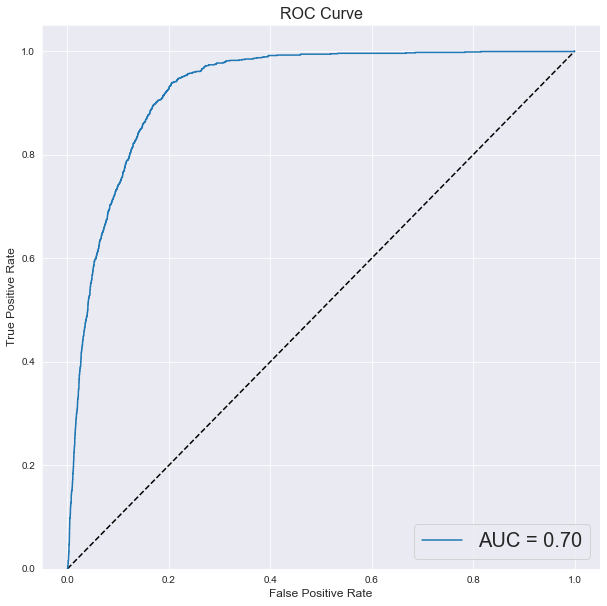

In [46]:
# generate plot
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate', fontsize = 12)
ax.set_ylabel('True Positive Rate', fontsize = 12)
ax.set_title('ROC Curve', fontsize = 16)
ax.set_ylim(0,)

# plot ROC curve
# get probabilities that y_test is predicted 1
y_pred_prob = log_reg_optimal.predict_proba(X_test_final)[:,1]
# get false positive and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# compute area under curve score
auc_score = roc_auc_score(y_test, y_pred)
# plot ROC curve on ax
ax.plot(fpr, tpr, label = 'AUC = {:.2f}'.format(auc_score))
plt.legend(loc = 'lower right', prop = {'size': 20})
plt.show()